In [75]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

## Experiment 3: JSD Experiment Performance
Here we transition to our third experiment which will implement Ossi's method. There are four different settings within this experiment. These are different baselines and then the fourth setting is the implementation with JSD. For each of the the four settings we will output a normalized confusion matrix along with accuracy metrics.

## Note: the settings are not in chronological order.

To start we import and initialize our language model

In [76]:
#Install transformers library and confusion matrix library
!python3.9 -m pip install --upgrade pip
%pip install transformers pycm==3.9
import warnings
warnings.filterwarnings("ignore")
import random
random.seed(299)

196449.13s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


zsh:1: command not found: python3.9


196454.34s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


In [77]:
from transformers import BertTokenizer, BertModel

#Choose a pretrained model from the transformers library
lm_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(lm_name)

In [78]:
#Select a classification dataset with two columns, 'text' and 'category'
#!wget https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv

# Downloaded manualy 

In [79]:

import pandas as pd
import numpy as np
df = pd.read_csv('/Users/hagitbenshoshan/Documents/PHD/NN/bbc-text.csv')

Clean the special chars and digits (reduced the keys to 29K instead of 43K)

In [80]:
#Create bag of words representation
from collections import Counter

import re
df['text'] = df['text'].str.replace('\W+',' ', regex=True)   


# import these modules
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
# Removing stop words
stop = stopwords.words('english')

df['cleantext'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


lmtzr = WordNetLemmatizer()
#df['lemmatize'] = df['text'].apply(
#                    lambda lst:[lmtzr.lemmatize(word) for word in lst])
  
  
 

In [81]:



all_bow = df['cleantext'].apply(lambda text : Counter(text.split()))
list_of_counters = all_bow

# Get the unique keys from all the counters
keys = sorted(set().union(*list_of_counters))

# Create a dictionary with keys as column names and values as arrays
col_arrays = {key: np.zeros(len(list_of_counters), dtype=int) for key in keys}
for i, counter in enumerate(list_of_counters):
    for key in counter:
        col_arrays[key][i] = counter[key]

# Stack the column arrays horizontally to create a matrix
matrix = np.column_stack(list(col_arrays.values()))

df['bow'] = list(matrix)

In [82]:
import torch

#Convert labels to integers
labels = {cat:i for i, cat in enumerate(df.category.unique())}

#Create dataset class
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):
        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text,
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [83]:
#Create a transformer classifier
class LMClassifier(torch.nn.Module):
    def __init__(self, n_labels):
        super(LMClassifier, self).__init__()

        self.bert = BertModel.from_pretrained(lm_name, force_download=True)
        self.linear = torch.nn.Linear(768, n_labels)
        self.activation = torch.nn.Softmax(dim=1)

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        linear_output = self.linear(pooled_output)
        final_layer = self.activation(linear_output)

        return final_layer

In [84]:
#create training script
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs, batch_size):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_size)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()

                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()

            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')

In [85]:
#create evaluation script, returns confusion matrix
def evaluate(model, test_data, batch_size):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=batch_size)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    confusion_matrix = np.zeros((len(labels), len(labels)))

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              for pred, true in zip(output.argmax(dim=1), test_label):
                confusion_matrix[true, pred] += 1

    return confusion_matrix

In [88]:
#Define hyperparameters
import copy
from pycm import ConfusionMatrix
import matplotlib.pyplot as plt

EPOCHS = 1
LR = 5e-6
BATCH_SIZE = 16
N_TESTS = 1

# Setting 3: Baseline Performance


For this setting of the third experiment we split the training dataset into 3 equal parts, randomly. We train on 1/3 of the train data and then end up labeling and training on an additional 10 percent of the previously unlabelled data randomly.

In [89]:
FINAL_CONF_MATRIX = np.zeros((len(labels), len(labels)))
for _ in range(N_TESTS):
  #Split data into training, additional, validation, and test
  df_train, df_val, df_test = np.split(df.sample(frac=1), [int(0.4 * len(df)), int(0.5*len(df))])

  MODEL = LMClassifier(len(labels))

  train(MODEL, df_train, df_val, LR, EPOCHS, BATCH_SIZE)
  CONF_MATRIX = evaluate(MODEL, df_test, BATCH_SIZE)
  FINAL_CONF_MATRIX += CONF_MATRIX

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

100%|██████████| 56/56 [05:21<00:00,  5.74s/it]


Epochs: 1 | Train Loss:  0.098                 | Train Accuracy:  0.485                 | Val Loss:  0.092                 | Val Accuracy:  0.820


Overall Statistics : 

ACC Macro                                                         0.98455
F1 Macro                                                          0.96072
FPR Macro                                                         0.00975
Kappa                                                             0.95148
NPV Macro                                                         0.99047
Overall ACC                                                       0.96137
PPV Macro                                                         0.9628
SOA1(Landis & Koch)                                               Almost Perfect
TPR Macro                                                         0.96017
Zero-one Loss                                                     43

Class Statistics :

Classes                                                           0             1             2             3             4             
ACC(Accuracy)                                                     0.97934     

<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

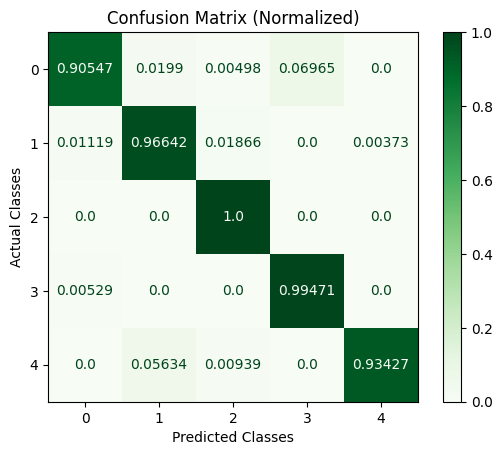

In [ ]:
cm = ConfusionMatrix(matrix=FINAL_CONF_MATRIX.astype(int))
cm.stat(summary=True)
cm.plot(cmap=plt.cm.Greens, number_label=True, normalized=True)

The results show the corresponding confusion matrix along with various accuracy metrics. Overall accuracy is about 90% and we can see there is some confusion within the confusion matrix. The results are better than the minimum performance below and worse than the maximum performance.

# Setting 1: Minimum Performance

For this setting of the third experiment we train on only 1/3 of the data.


In [90]:
FINAL_CONF_MATRIX = np.zeros((len(labels), len(labels)))
for _ in range(N_TESTS):
  #Split data into training, additional, validation, and test
  df_train, df_val, df_test = np.split(df.sample(frac=1), [int(0.3 * len(df)), int(0.5*len(df))])

  MODEL = LMClassifier(len(labels))

  train(MODEL, df_train, df_val, LR, EPOCHS, BATCH_SIZE)
  CONF_MATRIX = evaluate(MODEL, df_test, BATCH_SIZE)
  FINAL_CONF_MATRIX += CONF_MATRIX

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

100%|██████████| 42/42 [04:15<00:00,  6.08s/it]


Epochs: 1 | Train Loss:  0.099                 | Train Accuracy:  0.423                 | Val Loss:  0.095                 | Val Accuracy:  0.724


Overall Statistics : 

ACC Macro                                                         0.96658
F1 Macro                                                          0.91333
FPR Macro                                                         0.02092
Kappa                                                             0.89492
NPV Macro                                                         0.97963
Overall ACC                                                       0.91644
PPV Macro                                                         0.9225
SOA1(Landis & Koch)                                               Almost Perfect
TPR Macro                                                         0.91128
Zero-one Loss                                                     93

Class Statistics :

Classes                                                           0             1             2             3             4             
ACC(Accuracy)                                                     0.96226     

<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

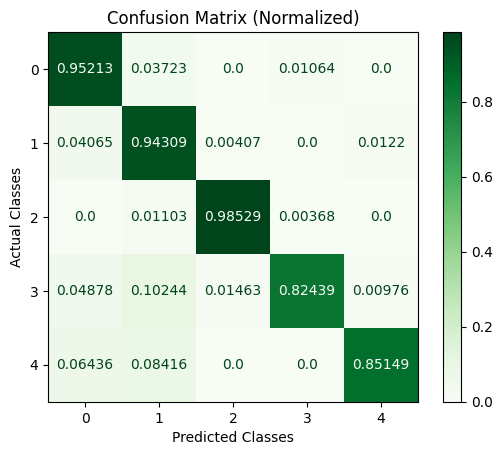

In [ ]:
cm = ConfusionMatrix(matrix=FINAL_CONF_MATRIX.astype(int))
cm.stat(summary=True)
cm.plot(cmap=plt.cm.Greens, number_label=True, normalized=True)

The results show the corresponding confusion matrix along with various accuracy metrics. As expected the accuracy is the lowest at about 82 percent and there is the most confusion in the confusion matrix.

#Setting 4: JSD Experiment Performance

In [ ]:
FINAL_CONF_MATRIX = np.zeros((len(labels), len(labels)))
for _ in range(N_TESTS):
  #Split data into training, additional, validation, and test
  df_train, df_addl, df_test = np.split(df.sample(frac=1), [int(0.3 * len(df)), int(0.5*len(df))])

  MODEL = LMClassifier(len(labels))

  bow_mean = df_train['bow'].mean()

  def jsd_signaturizer(item):
    M = (bow_mean + item) / 2
    S = bow_mean * np.nan_to_num(np.log2(M/bow_mean)) / 2 + item * np.nan_to_num(np.log2(M/item)) / 2
    res = np.array([s if m >= b else -s for s, b, m in zip(S, bow_mean, M)])
    args = abs(res).argsort()
    res[args[:int(0.98 * len(args))]] = 0.0
    return res

  df_train['signatures_jsd'] = df_train['bow'].apply(jsd_signaturizer)
  df_addl['signatures_jsd'] = df_addl['bow'].apply(jsd_signaturizer)

  l2_dist = lambda v1, v2 : np.linalg.norm(v1 - v2)
  jsd_signatures_distances = df_addl['signatures_jsd'].apply(lambda v1 : df_train['signatures_jsd'].apply(lambda v2 : l2_dist(v1, v2)).min())

  inds_to_add_top = jsd_signatures_distances.sort_values().index[len(df_addl)//2:]
  inds_to_add_bttm = jsd_signatures_distances.sort_values().index[:len(df_addl)//2]
  df_val = df_addl.loc[inds_to_add_bttm]

  df_train_jsd_signature_top = pd.concat([df_addl.loc[inds_to_add_top], df_train], ignore_index=True, axis=0)

  train(MODEL, df_train_jsd_signature_top, df_val, LR, EPOCHS, BATCH_SIZE)
  CONF_MATRIX = evaluate(MODEL, df_test, BATCH_SIZE)
  FINAL_CONF_MATRIX += CONF_MATRIX

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

100%|██████████| 56/56 [16:08<00:00, 17.30s/it] 


Epochs: 1 | Train Loss:  0.098                 | Train Accuracy:  0.458                 | Val Loss:  0.091                 | Val Accuracy:  0.820


100%|██████████| 56/56 [12:04<00:00, 12.93s/it]


Epochs: 2 | Train Loss:  0.084                 | Train Accuracy:  0.879                 | Val Loss:  0.077                 | Val Accuracy:  0.986


Overall Statistics : 

ACC Macro                                                         0.97951
F1 Macro                                                          0.94863
FPR Macro                                                         0.01298
Kappa                                                             0.93569
NPV Macro                                                         0.98728
Overall ACC                                                       0.94879
PPV Macro                                                         0.95138
SOA1(Landis & Koch)                                               Almost Perfect
TPR Macro                                                         0.94669
Zero-one Loss                                                     57

Class Statistics :

Classes                                                           0             1             2             3             4             
ACC(Accuracy)                                                     0.97664    

<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

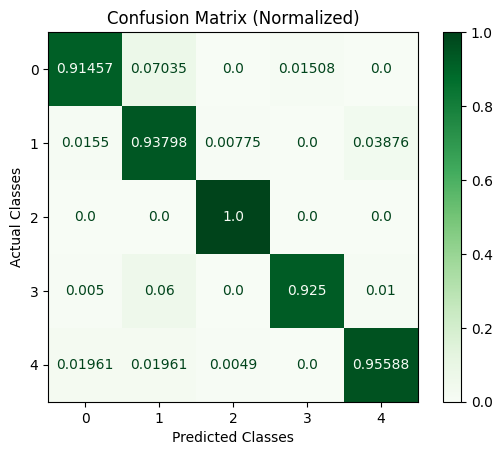

In [ ]:
cm = ConfusionMatrix(matrix=FINAL_CONF_MATRIX.astype(int))
cm.stat(summary=True)
cm.plot(cmap=plt.cm.Greens, number_label=True, normalized=True)

We see that the method worked better than the the baseline. Our overall accuracy is about 96 percent equal to our maximum performance when we train on more data (50% of the data set). The confusion matrix also looks good. The method works as we have trained on less data and received better results.

# Setting 2: Maximum Performance


For this experiment, we train on half the dataset

In [ ]:
FINAL_CONF_MATRIX = np.zeros((len(labels), len(labels)))
for _ in range(N_TESTS):
  #Split data into training, additional, validation, and test
  df_train, df_test = np.split(df.sample(frac=1), [int(0.5 * len(df))])

  MODEL = LMClassifier(len(labels))

  train(MODEL, df_train, df_test, LR, EPOCHS, BATCH_SIZE)
  CONF_MATRIX = evaluate(MODEL, df_test, BATCH_SIZE)
  FINAL_CONF_MATRIX += CONF_MATRIX

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

100%|██████████| 70/70 [06:15<00:00,  5.36s/it]


Epochs: 1 | Train Loss:  0.095                 | Train Accuracy:  0.562                 | Val Loss:  0.087                 | Val Accuracy:  0.854


100%|██████████| 70/70 [06:08<00:00,  5.26s/it]


Epochs: 2 | Train Loss:  0.079                 | Train Accuracy:  0.942                 | Val Loss:  0.072                 | Val Accuracy:  0.977


Overall Statistics : 

ACC Macro                                                         0.99066
F1 Macro                                                          0.9765
FPR Macro                                                         0.00585
Kappa                                                             0.97064
NPV Macro                                                         0.99412
Overall ACC                                                       0.97664
PPV Macro                                                         0.97616
SOA1(Landis & Koch)                                               Almost Perfect
TPR Macro                                                         0.97696
Zero-one Loss                                                     26

Class Statistics :

Classes                                                           0             1             2             3             4             
ACC(Accuracy)                                                     0.98832     

<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

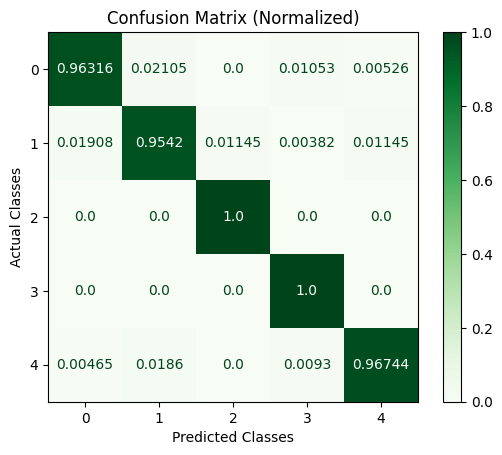

In [ ]:
cm = ConfusionMatrix(matrix=FINAL_CONF_MATRIX.astype(int))
cm.stat(summary=True)
cm.plot(cmap=plt.cm.Greens, number_label=True, normalized=True)

The corresponding confusion matrix and other metrics show the results of setting 2 above. The overall maximum accuracy is about 96 percent. We train on fifty percent of the data the most out of the four settings.

# Conclusion

To conclude the third experiment shows that the method works. In setting 4 we achieve equal accuracy while training on less data than in setting 2. Additionally there is a 6% increase in overall accuracy and less confusion between settings 3 and 4. Readers should refer to the accompanying report/blog post for additional information and analysis